# Necessary включения

In [624]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

print(sys.executable)


import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize


train = pd.read_csv("train.tsv")
test = pd.read_csv("test.tsv")
sample_submission = pd.read_csv("sample_submission.tsv")

C:\Users\Xiaomi\Anaconda3\python.exe


# Анализ

## Основные показатели

In [625]:
print('Всего данных в train:', len(train['item_id']))
print('Всего данных в test:', len(test['item_id']))
print('Число различных товаров в train:', train['item_id'].nunique())
print('Число различных товаров в test:', test['item_id'].nunique())
print('В среднем данных на каждый товар в train:', np.ceil(len(train['item_id']) / train['item_id'].nunique()))
print('В среднем данных на каждый товар в test:', np.ceil(len(test['item_id']) / test['item_id'].nunique()))
print('Число товаров из test, которых нет в train:', len([item for item in list(test['item_id']) if item not in list(train['item_id'])]))
        

Всего данных в train: 72457
Всего данных в test: 2016
Число различных товаров в train: 286
Число различных товаров в test: 227
В среднем данных на каждый товар в train: 254.0
В среднем данных на каждый товар в test: 9.0
Число товаров из test, которых нет в train: 0


In [626]:
import datetime

def to_datetime(dt):
    date_temp = []
    for index, row in dt.iterrows():
        date_temp.append((datetime.datetime.strptime(str(int(row['year'])) + '-W' + str(int(row['week'])) + '-1', "%Y-W%W-%w")).strftime('%Y-%m-%d'))
    dt['date'] = date_temp
    dt['date'] = pd.to_datetime(dt.date)

In [627]:
to_datetime(train)

## Кусок данных

In [628]:
train[:200]

,Num,y,year,week,shift,item_id,f1,f2,f3,f4,...,f52,f53,f54,f55,f56,f57,f58,f59,f60,date
0,0,123438,2012,52,1,20442076,4915.0,38056.0,40185.0,45733.0,...,41765.0,52590.0,31452.0,44420.0,41865.0,52705.0,36102.0,44163.0,45239.0,2012-12-24
1,1,58410,2012,52,1,20441997,2230.0,18817.0,20110.0,26368.0,...,25230.0,27850.0,21390.0,27090.0,23170.0,29705.0,19140.0,22055.0,23200.0,2012-12-24
2,2,163930,2012,52,1,20441990,5695.0,47480.0,47619.0,89708.0,...,44290.0,46412.0,29320.0,21140.0,28406.0,65056.0,31886.0,48750.0,36520.0,2012-12-24
3,3,53902,2012,52,1,20441989,1995.0,17146.0,20066.0,27070.0,...,12480.0,19780.0,7990.0,8230.0,10650.0,21920.0,13040.0,9780.0,9630.0,2012-12-24
4,4,105970,2012,52,1,20441988,6515.0,49262.0,50045.0,95167.0,...,19328.0,37168.0,13570.0,19760.0,20208.0,34745.0,18442.0,24700.0,21793.0,2012-12-24
5,5,21171,2012,52,1,20441953,445.0,3020.0,2395.0,4015.0,...,7690.0,13448.0,3455.0,7205.0,8490.0,10790.0,7855.0,8150.0,7505.0,2012-12-24
6,6,63128,2012,52,1,20441952,445.0,3930.0,4260.0,6836.0,...,8064.0,15275.0,4991.0,9025.0,12236.0,19830.0,8465.0,10770.0,13145.0,2012-12-24
7,7,44001,2012,52,1,20441951,1167.0,15220.0,12310.0,17270.0,...,20376.0,25385.0,11685.0,21389.0,16685.0,22805.0,14495.0,16462.0,19383.0,2012-12-24
8,8,53202,2012,52,1,20441790,1640.0,22010.0,17716.0,21941.0,...,17758.0,26181.0,11090.0,17705.0,17225.0,23385.0,13711.0,17175.0,22406.0,2012-12-24
9,9,36627,2012,52,1,20441789,1440.0,14601.0,12127.0,17498.0,...,15015.0,18574.0,9146.0,14865.0,13051.0,17389.0,10739.0,13260.0,15570.0,2012-12-24


## Корреляция признаков

In [629]:
print(train[['y','f30']].corr())
print(train[['y','f29']].corr())
print(train[['y','f1']].corr())
print(train[['f30','f60']].corr())
print(train[['f29','f30']].corr())


            y       f30
y    1.000000  0.923167
f30  0.923167  1.000000
            y       f29
y    1.000000  0.929594
f29  0.929594  1.000000
           y        f1
y   1.000000  0.892962
f1  0.892962  1.000000
     f30  f60
f30  1.0  1.0
f60  1.0  1.0
          f29       f30
f29  1.000000  0.934536
f30  0.934536  1.000000


## Разделение по item_id

Минимальное значение длины датасета для отдельного item_id: 3
Максимальное значение длины датасета для отдельного item_id: 321


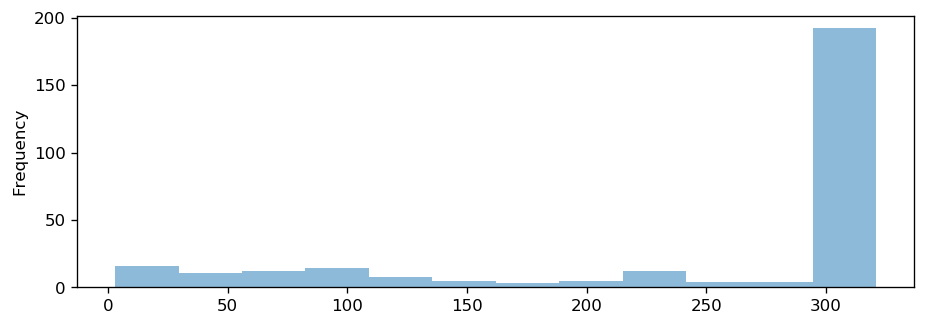

In [630]:
item_id_counter = train.groupby('item_id')['y'].count()
print("Минимальное значение длины датасета для отдельного item_id:", item_id_counter.min())
print("Максимальное значение длины датасета для отдельного item_id:", item_id_counter.max())
image = item_id_counter.plot.hist(bins=12, alpha=0.5)
train_sort = train.sort_values(by=['item_id', 'shift', 'year', 'week'])


In [631]:
train_sort[:120]

,Num,y,year,week,shift,item_id,f1,f2,f3,f4,...,f52,f53,f54,f55,f56,f57,f58,f59,f60,date
150,150,340138,2012,52,1,20427028,9700.0,92038.0,111363.0,146522.0,...,113945.0,156656.0,69913.0,96291.0,112953.0,164259.0,88789.0,108817.0,110228.0,2012-12-24
841,3613,110776,2013,1,1,20427028,92038.0,111363.0,146522.0,174408.0,...,156656.0,69913.0,96291.0,112953.0,164259.0,88789.0,108817.0,110228.0,211266.0,2013-01-07
1536,7079,70915,2013,2,1,20427028,111363.0,146522.0,174408.0,111337.0,...,69913.0,96291.0,112953.0,164259.0,88789.0,108817.0,110228.0,211266.0,68805.0,2013-01-14
2240,10552,149741,2013,3,1,20427028,146522.0,174408.0,111337.0,124149.0,...,96291.0,112953.0,164259.0,88789.0,108817.0,110228.0,211266.0,68805.0,44047.0,2013-01-21
2919,13997,203508,2013,4,1,20427028,174408.0,111337.0,124149.0,119286.0,...,112953.0,164259.0,88789.0,108817.0,110228.0,211266.0,68805.0,44047.0,93007.0,2013-01-28
3617,17455,195400,2013,5,1,20427028,111337.0,124149.0,119286.0,125648.0,...,164259.0,88789.0,108817.0,110228.0,211266.0,68805.0,44047.0,93007.0,126403.0,2013-02-04
4316,20908,120347,2013,6,1,20427028,124149.0,119286.0,125648.0,143969.0,...,88789.0,108817.0,110228.0,211266.0,68805.0,44047.0,93007.0,126403.0,121367.0,2013-02-11
5015,24360,158134,2013,7,1,20427028,119286.0,125648.0,143969.0,97244.0,...,108817.0,110228.0,211266.0,68805.0,44047.0,93007.0,126403.0,121367.0,74750.0,2013-02-18
5712,27810,139039,2013,8,1,20427028,125648.0,143969.0,97244.0,117698.0,...,110228.0,211266.0,68805.0,44047.0,93007.0,126403.0,121367.0,74750.0,98220.0,2013-02-25
6466,31322,224751,2013,9,1,20427028,143969.0,97244.0,117698.0,119425.0,...,211266.0,68805.0,44047.0,93007.0,126403.0,121367.0,74750.0,98220.0,86360.0,2013-03-04


## Признаковый анализ

In [632]:
# Добавляем временной столбец
temp = []
for index, row in train_sort.iterrows():
    temp.append(train_sort['year'][index] * 100 + train_sort['week'][index])
train_sort['time']=temp

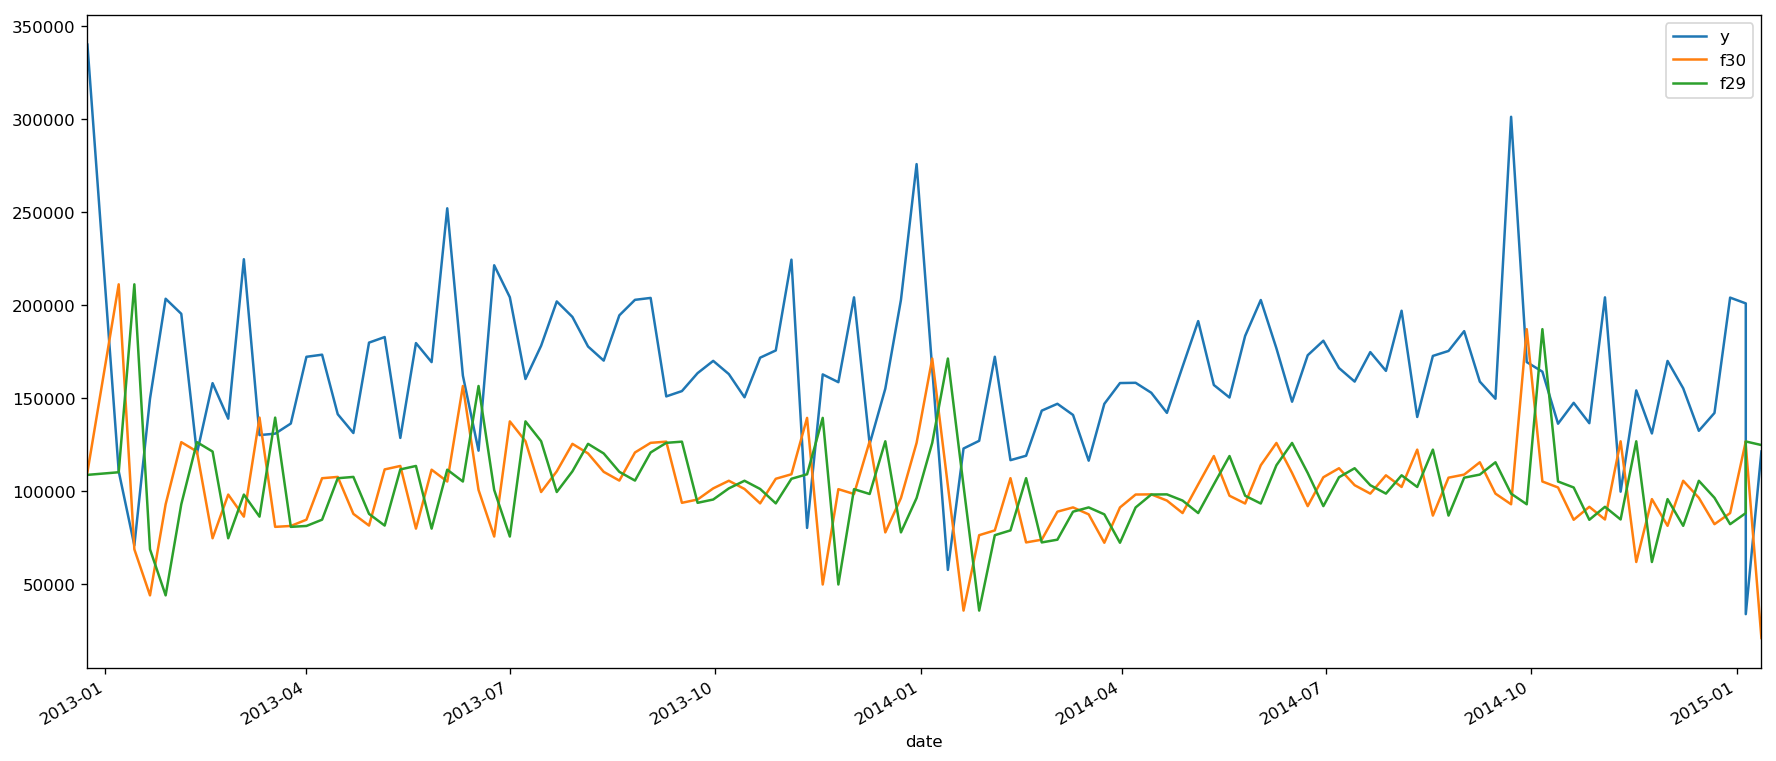

In [633]:
train_sort[:108].plot(x="date", y=["y","f30","f29"],figsize=(18,8))

# Handling функции

In [634]:
def make_sort(dt):
    return dt.sort_values(by=['item_id', 'shift', 'year', 'week'])

def append_time(dt):
    temp = []
    for index, row in dt.iterrows():
        temp.append(dt['year'][index] * 100 + dt['week'][index])
    dt['time']=temp
    
def append_count(dt):
    temp_dict = {str(key):0 for key in dt['item_id']}
    for index,row in dt.iterrows():
        temp_dict[str(int(row['item_id']))] += 1
    temp_array = []
    for index,row in dt.iterrows():
        temp_array.append(temp_dict[str(int(row['item_id']))])
    dt['count'] = temp_array
    
def append_date(dt):
    date_temp = []
    for index, row in dt.iterrows():
        date_temp.append((datetime.datetime.strptime(str(int(row['year'])) + '-W' + str(int(row['week'])) + '-1', "%Y-W%W-%w")).strftime('%Y-%m-%d'))
    dt['date'] = date_temp
    dt['date'] = pd.to_datetime(dt.date)

def make_dict(dt):
    dt_dict = {}
    index = 0
    old_index = dt.index
    dt_len = len(dt['item_id'])
    dt.index = range(dt_len)
    while index < dt_len:
        dt_dict.update({dt['item_id'][index]: dt[index:index + dt['count'][index]]})
        index += dt['count'][index]
    dt.index = old_index
    return dt_dict

def make_dict2(dt):
    dt_dict = {str(key):pd.DataFrame(columns=dt.columns) for key in dt['item_id']}
    for index,row in dt.iterrows():
        dt_dict[str(int(row['item_id']))].append(row)
    return dt_dict
    
def make_shift(dt, columns_copy):
    temp_id = dt['item_id'][0]
    dt_len = len(dt['item_id'])
    old_indexes = list(dt.head().index)
    dt.index = range(dt_len)
    for index in range(dt_len - 1):
        if not temp_id == dt['item_id'][index + 1]:
            temp_id = dt['item_id'][index + 1]
            continue
        else:
            for column in columns_copy:
                dt[column][index] = dt[column][index + 1]
    dt.index = old_indexes

def make_train(dt, coef = 0.62):
    ret_x = []
    ret_y = []
    all_dates = [201222 + i for i in range(30)] + list(train_sort['time'].unique())
    dates = list(dt['time'].unique())
    all_values = {date: -1 for date in all_dates}
    for index, row in dt.iterrows():
        row_shift = int(row['shift'])
        date = row['time'] - row_shift
        if not date in all_dates:
            continue
        index_date = all_dates.index(date)
        for shift in range(0, min(30, index_date + 1)):
            all_values[all_dates[index_date - shift]] = row['f' + str(30 - shift)]
    ret_x = list(all_values.values())
    ret_y = list(all_values.values())
    for index in range(len(ret_x)):
        ret_y[index] = ret_x[index] / coef
    for index, row in dt.iterrows():
        ret_y[all_dates.index(row['time'])] = row['y']
    temp_dict = []
    for index, date in enumerate(all_dates):
        if not ret_x[index] == -1:
            temp_dict.append({'x': ret_x[index], 'y': ret_y[index], 'time': date,
                              'year':int(str(date)[:4]), 'week': int(str(date)[4:])})
    return pd.DataFrame(temp_dict)

def make_recover(dt, coef):
    ret_x = []
    ret_y = []
    all_dates = [201222 + i for i in range(30)] + list(train_sort['time'].unique())
    dates = list(dt['time'].unique())
    all_values = {date: -1 for date in all_dates}
    for index, row in dt.iterrows():
        row_shift = int(row['shift'])
        date = row['time'] - row_shift
        if not date in all_dates:
            continue
        index_date = all_dates.index(date)
        for shift in range(0, min(30, index_date + 1)):
            all_values[all_dates[index_date - shift]] = row['f' + str(30 - shift)]
    ret_x = list(all_values.values())
    ret_y = list(all_values.values())
    for index in range(len(ret_x)):
        ret_y[index] = ret_x[index] / coef
    for index, row in dt.iterrows():
        ret_y[all_dates.index(row['time'])] = row['y']
    temp_dict = []
    for index, date in enumerate(all_dates):
        if not ret_x[index] == -1:
            temp_dict.append({'x': ret_x[index], 'y': ret_y[index], 'time': date})
    return pd.DataFrame(temp_dict)            

# Обработка данных

In [635]:
handle_train = make_sort(train)
append_time(handle_train)
append_count(handle_train)
append_date(handle_train)
train_dict = make_dict(handle_train)

In [636]:
keys = list(train_dict.keys())
df = train_dict[keys[0]][:108].copy()

In [637]:
def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))).fillna(0))
    

# Тренировка

In [638]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
dates = list(train_sort['time'].unique())

In [639]:
trains_dates_dict = {}
for item in train_dict:
    dtt = make_train(train_dict[item])
    if dtt.empty:
        trains_dates_dict.update({item: make_recover(train_dict[item], 0.62)})
    else:
        trains_dates_dict.update({item: dtt})

In [640]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
def get_model_GB(X, Y):
    param_test1 = {'n_estimators':range(10,301,10)}
    gsearch1 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1, max_depth=10,subsample=0.7,random_state=47), 
    param_grid = param_test1, scoring=make_scorer(smape_kun, greater_is_better=False),n_jobs=4,iid=False, cv=5)
    if isinstance(X,pd.Series):
        X_temp = np.array(X).reshape(-1, 1)
        gsearch1.fit(X_temp,Y)
    else:
        gsearch1.fit(X,Y)
    return {'smape': -gsearch1.best_score_, 'param': gsearch1.best_params_['n_estimators']}

    
def get_model_LR(X, Y):
    grid = {'alpha': [0.1 * i for i in range(1, 11)] + [100 * i for i in range(1,11)]}
    logreg = Ridge()
    gsearch1 = GridSearchCV(estimator = logreg, 
    param_grid = grid, scoring=make_scorer(smape_kun, greater_is_better=False),n_jobs=4,iid=False, cv=5)
    if isinstance(X,pd.Series):
        X_temp = np.array(X).reshape(-1, 1)
        gsearch1.fit(X_temp,Y)
    else:
        gsearch1.fit(X,Y)
    return {'smape': -gsearch1.best_score_, 'param': gsearch1.best_params_['alpha']}
    
def get_model_LL(X, Y):
    grid = {'alpha': [0.1 * i for i in range(1, 11)] + [100 * i for i in range(1,11)]}
    logreg = Lasso()
    gsearch1 = GridSearchCV(estimator = logreg, 
    param_grid = grid, scoring=make_scorer(smape_kun, greater_is_better=False),n_jobs=4,iid=False, cv=5)
    if isinstance(X,pd.Series):
        X_temp = np.array(X).reshape(-1, 1)
        gsearch1.fit(X_temp,Y)
    else:
        gsearch1.fit(X,Y)
    return {'smape': -gsearch1.best_score_, 'param': gsearch1.best_params_['alpha']}


In [641]:
index = 185
# print(trains_dates_dict[keys[index]])
print(get_model_GB(trains_dates_dict[keys[index]]['time'],trains_dates_dict[keys[index]]['y']))
print(get_model_GB(trains_dates_dict[keys[index]][['year', 'week']],trains_dates_dict[keys[index]]['y']))

print(get_model_LR(trains_dates_dict[keys[index]]['time'],trains_dates_dict[keys[index]]['y']))
print(get_model_LR(trains_dates_dict[keys[index]][['year', 'week']],trains_dates_dict[keys[index]]['y']))

print(get_model_LL(trains_dates_dict[keys[index]]['time'],trains_dates_dict[keys[index]]['y']))
print(get_model_LL(trains_dates_dict[keys[index]][['year', 'week']],trains_dates_dict[keys[index]]['y']))



{'smape': 51.76171334324255, 'param': 40}
{'smape': 53.529134562707476, 'param': 10}
{'smape': 61.790028926534276, 'param': 1000}
{'smape': 57.26189747180018, 'param': 100}
{'smape': 61.733973451722605, 'param': 1000}
{'smape': 57.35273202930189, 'param': 700}


In [642]:
index = 185
# print(trains_dates_dict[keys[index]])
print(get_model_GB(trains_dates_dict[keys[index]][['x', 'time']],trains_dates_dict[keys[index]]['y']))
print(get_model_GB(trains_dates_dict[keys[index]][['x', 'year', 'week']],trains_dates_dict[keys[index]]['y']))

print(get_model_LR(trains_dates_dict[keys[index]][['x', 'time']],trains_dates_dict[keys[index]]['y']))
print(get_model_LR(trains_dates_dict[keys[index]][['x', 'year', 'week']],trains_dates_dict[keys[index]]['y']))

print(get_model_LL(trains_dates_dict[keys[index]][['x', 'time']],trains_dates_dict[keys[index]]['y']))
print(get_model_LL(trains_dates_dict[keys[index]][['x', 'year', 'week']],trains_dates_dict[keys[index]]['y']))


{'smape': 24.630860524744488, 'param': 90}
{'smape': 19.83982906128031, 'param': 190}
{'smape': 12.732201251490633, 'param': 1000}
{'smape': 12.013756123737648, 'param': 1000}
{'smape': 11.989452774426432, 'param': 1000}
{'smape': 11.989452774426432, 'param': 1000}


In [643]:
def get_optimal_main_model(dt):
    scoreGB = get_model_GB(dt[['x', 'year', 'week']],dt['y'])
    scoreLR = get_model_LR(dt[['x', 'year', 'week']],dt['y'])
    scoreLL = get_model_LL(dt[['x', 'year', 'week']],dt['y'])
    min_score = min([score_m['smape'] for score_m in [scoreGB,scoreLR,scoreLL]])
    if scoreGB['smape'] == min_score:
        return GradientBoostingRegressor(learning_rate=0.05, max_depth=10,subsample=0.8,random_state=47, n_estimators=scoreGB['param'])
    if scoreLR['smape'] == min_score:
        return Ridge(alpha = scoreGB['param'])
    else:
        return Lasso(alpha = scoreLL['param'])
    
def get_optimal_extra_model(dt):
    scoreGB = get_model_GB(dt[['year', 'week']],dt['y'])
    scoreLR = get_model_LR(dt[['year', 'week']],dt['y'])
    scoreLL = get_model_LL(dt[['year', 'week']],dt['y'])
    min_score = min([score_m['smape'] for score_m in [scoreGB,scoreLR,scoreLL]])
    if scoreGB['smape'] == min_score:
        return GradientBoostingRegressor(learning_rate=0.05, max_depth=10,subsample=0.8,random_state=47, n_estimators=scoreGB['param'])
    if scoreLR['smape'] == min_score:
        return Ridge(alpha = scoreGB['param'])
    else:
        return Lasso(alpha = scoreLL['param'])

In [644]:
models_dict = {}
count = 1
for item in trains_dates_dict:
#     main model
    print(count)
    count += 1
    models_dict.update({item: {'main': get_optimal_main_model(trains_dates_dict[item]), 
                              'extra': get_optimal_extra_model(trains_dates_dict[item])}})

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [645]:
for item in models_dict:
    models_dict[item]['main'].fit(trains_dates_dict[item][['x', 'year', 'week']], trains_dates_dict[item]['y'])
    models_dict[item]['extra'].fit(trains_dates_dict[item][['year', 'week']], trains_dates_dict[item]['y'])

In [646]:
predict_dict = {}
for item in models_dict:
    predict_dict.update({item: {'predict_main': models_dict[item]['main'].predict(
        trains_dates_dict[item][['x', 'year', 'week']]),
                              'predict_extra': models_dict[item]['extra'].predict(
        trains_dates_dict[item][['year', 'week']])}})


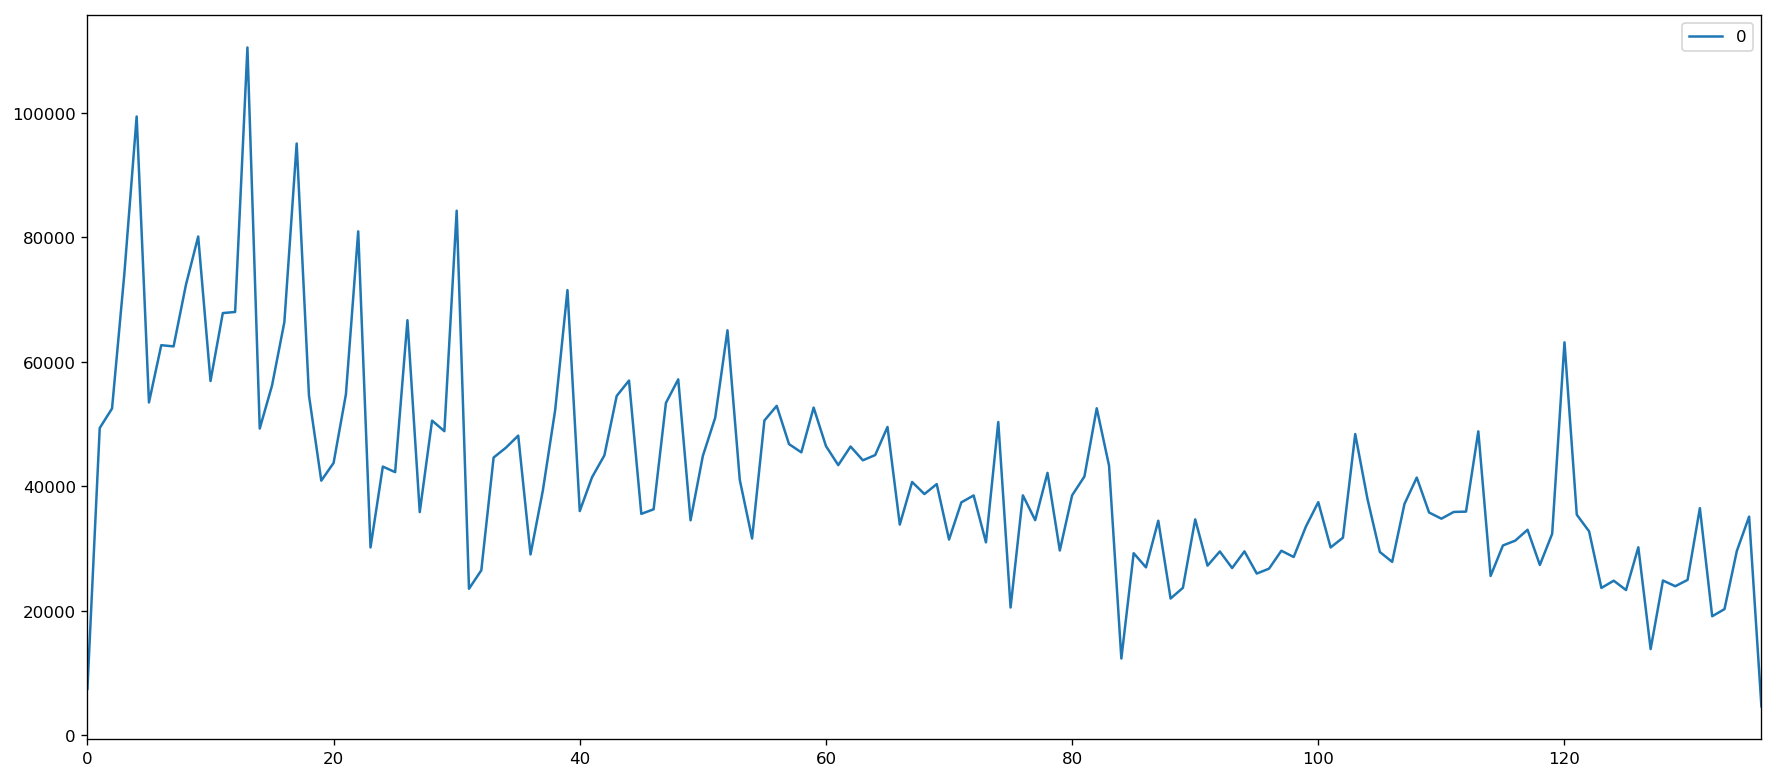

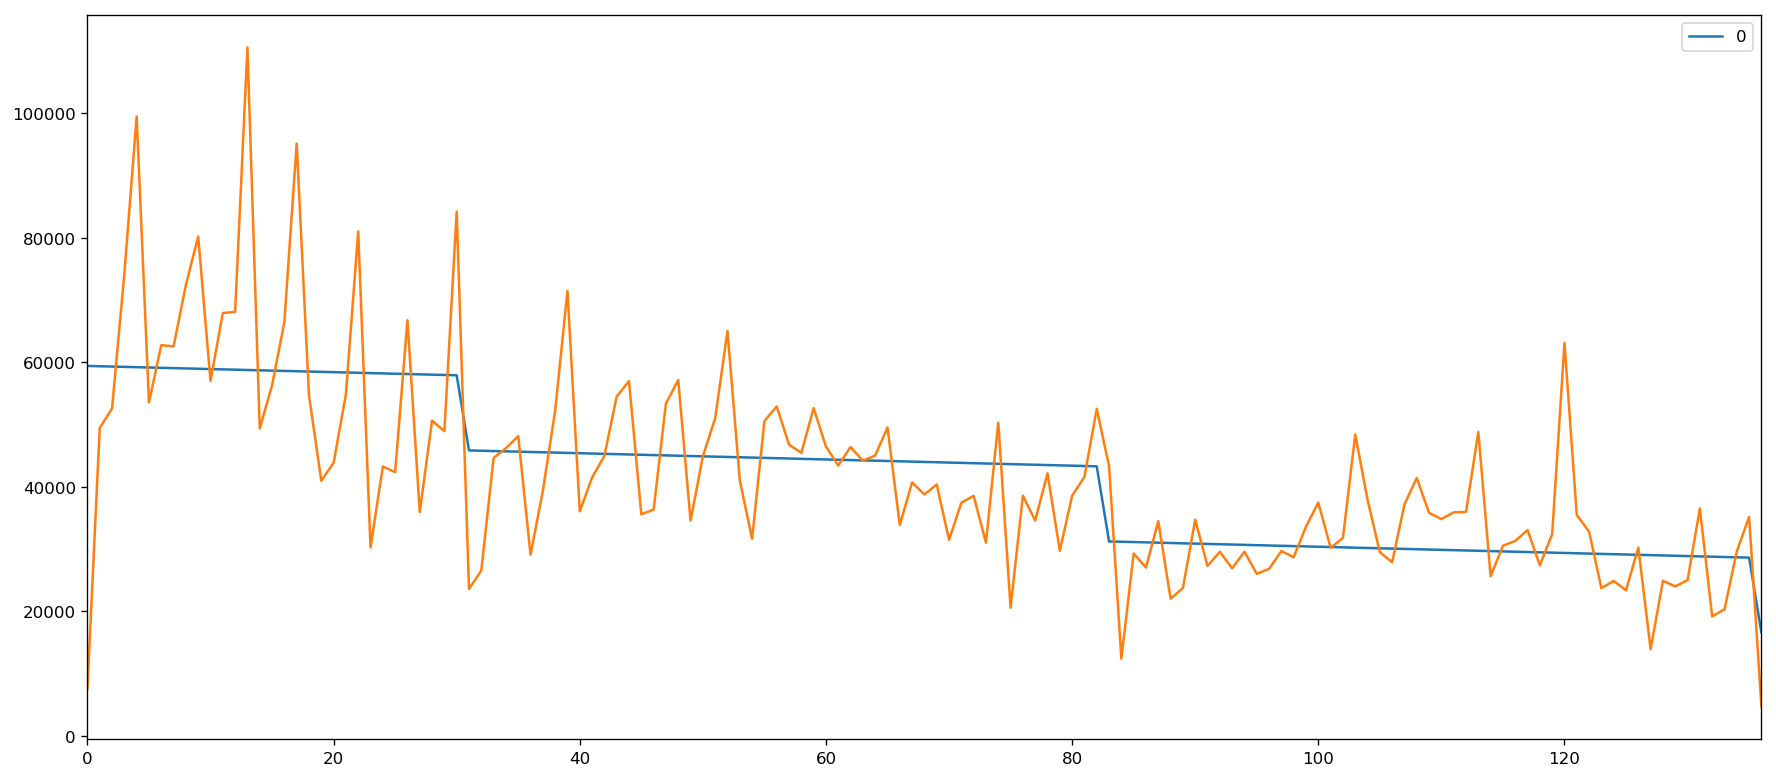

In [647]:
items = list(predict_dict.keys())
time_all = [201222 + i for i in range(30)] + list(train_sort['time'].unique())
pd.DataFrame(predict_dict[items[30]]['predict_main']).plot.line(figsize=(18,8))

pd.DataFrame(predict_dict[items[30]]['predict_extra']).plot.line(figsize=(18,8))
trains_dates_dict[items[30]]['y'].plot.line()

In [666]:
def make_test(dt):
    dates = list(dt['time'].unique())
    temp_x = []
    count = 0
    for index, row in dt.iterrows():
        time = row['time']
        row_shift = dt.loc[(dt['time'] - dt['shift'] >= time)]
        if not row_shift.empty:
            shift = int(row_shift['time'][row_shift.index[0]]) - int(row_shift['shift'][row_shift.index[0]]) - int(time)
            temp_x.append(int(row_shift['f' + str(30 - shift)][row_shift.index[0]]))
        else:
            if len(temp_x) == 2:
                temp_x.append((temp_x[0] + temp_x[1])/2)
            else:
                if len(temp_x) == 1:
                    temp_x.append(-1)
                else:
                    if len(temp_x) == 0:
                        temp_x.append(-1)
                    else:
                        temp_x.append(temp_x[count % 3])
        count += 1;
    dt['x'] = temp_x


#  Предсказания

Минимальное значение длины датасета для отдельного item_id: 3
Максимальное значение длины датасета для отдельного item_id: 9


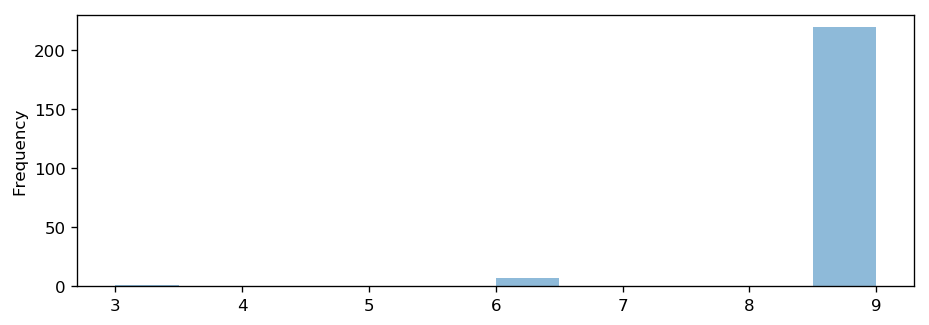

In [667]:
item_id_counter = test.groupby('item_id')['item_id'].count()
print("Минимальное значение длины датасета для отдельного item_id:", item_id_counter.min())
print("Максимальное значение длины датасета для отдельного item_id:", item_id_counter.max())
image = item_id_counter.plot.hist(bins=12, alpha=0.5)
test_sort = test.sort_values(by=['item_id', 'shift', 'year', 'week'])


In [668]:
handle_test = make_sort(test)
append_time(handle_test)
append_count(handle_test)
test_dict = make_dict(handle_test)

In [669]:
for item in test_dict:
    make_test(test_dict[item])

In [670]:
count = 0
for item in test_dict:
    if len(test_dict[item]['x']) < 9:
        print(test_dict[item][['x', 'f29', 'f30', 'time', 'shift']])
        count += 1
print(count)

     x    f29    f30    time  shift
18  90  160.0    0.0  201503      1
19  -1    0.0   90.0  201504      1
20  90  290.0  160.0  201503      2
21  90  160.0    0.0  201504      2
22  90  330.0  290.0  201503      3
23  90  290.0  160.0  201504      3
       x    f29    f30    time  shift
105  120   30.0   70.0  201503      1
106   -1   70.0  120.0  201504      1
107  120  130.0   30.0  201503      2
108  120   30.0   70.0  201504      2
109  120  270.0  130.0  201503      3
110  120  130.0   30.0  201504      3
       x   f29    f30    time  shift
525  120   0.0   40.0  201503      1
526   -1  40.0  120.0  201504      1
527  120  40.0    0.0  201503      2
528  120   0.0   40.0  201504      2
529  120  40.0   40.0  201503      3
530  120  40.0    0.0  201504      3
       x   f29    f30    time  shift
531  160   0.0   20.0  201503      1
532   -1  20.0  160.0  201504      1
533  160   0.0    0.0  201503      2
534  160   0.0   20.0  201504      2
535  160   0.0    0.0  201503      3
5

In [671]:
for item in test_dict:
    temp_pred = []
    for index, row in test_dict[item].iterrows():
        if row['x'] == -1:
            temp_pred.append(models_dict[item]['extra'].predict([[row['year'], row['week']]])[0])
        else:
            temp_pred.append(models_dict[item]['main'].predict([[row['x'], row['year'], row['week']]])[0])
    test_dict[item]['pred'] = temp_pred

In [672]:
print(test_dict[keys[0]])

      Num  year  week  shift   item_id        f1        f2        f3  \
0  350335  2015     3      1  20427028  112386.0  103264.0   98742.0   
1  351009  2015     4      1  20427028  103264.0   98742.0  108584.0   
2  351449  2015     5      1  20427028   98742.0  108584.0  102320.0   
3  349663  2015     3      2  20427028  107536.0  112386.0  103264.0   
4  350563  2015     4      2  20427028  112386.0  103264.0   98742.0   
5  351229  2015     5      2  20427028  103264.0   98742.0  108584.0   
6  348766  2015     3      3  20427028   92012.0  107536.0  112386.0   
7  349891  2015     4      3  20427028  107536.0  112386.0  103264.0   
8  350783  2015     5      3  20427028  112386.0  103264.0   98742.0   

         f4        f5  ...       f55       f56       f57       f58       f59  \
0  108584.0  102320.0  ...   82307.0   88269.0  126779.0  124853.0   21081.0   
1  102320.0  122395.0  ...   88269.0  126779.0  124853.0   21081.0   75404.0   
2  122395.0   86925.0  ...  126779.0  1

In [673]:
pred = []
for index, row in test.iterrows():
    pred.append(int(test_dict[row['item_id']].loc[test_dict[row['item_id']]['Num'] == row['Num']]['pred']))
out_data = test.copy()
out_data['y'] = pred
print(out_data)

         Num  year  week  shift   item_id        f1        f2        f3  \
0     348622  2015     3      3  20447918     960.0     820.0    1128.0   
1     348623  2015     3      3  20447902    9086.0   12585.0   11595.0   
2     348624  2015     3      3  20447732  115087.0  147287.0  176065.0   
3     348625  2015     3      3  20443951   20900.0   24420.0   27068.0   
4     348626  2015     3      3  20443944    4430.0    5864.0    3310.0   
5     348627  2015     3      3  20443943   57289.0   80036.0  112511.0   
6     348628  2015     3      3  20443941   21868.0   30620.0   45886.0   
7     348629  2015     3      3  20443902   41105.0   57637.0   54540.0   
8     348630  2015     3      3  20443901   39381.0   56933.0   59899.0   
9     348631  2015     3      3  20443308    5922.0   16070.0   14665.0   
10    348632  2015     3      3  20443307    5120.0    9280.0    9015.0   
11    348633  2015     3      3  20443057   52035.0   64435.0   63748.0   
12    348634  2015     3 

[2016 rows x 66 columns]


In [674]:
out_data[['Num', 'y']].to_csv('submission.csv', index = False)

In [103]:
handle_train =pd.read_csv("handle_train.csv")
handle_train.index = train_sort.index

In [105]:
print(handle_train[105:120][['y','f29','f30','time','shift']])
print(train_sort[105:120][['y','f29','f30','time','shift']])

            y       f29       f30    time  shift
71257  201013   88269.0  126779.0  201453      1
71925   33940  126779.0  124853.0  201501      1
72376  121400  124853.0   21081.0  201502      1
380    110776  108817.0  110228.0  201301      2
1072    70915  110228.0  211266.0  201302      2
1780   149741  211266.0   68805.0  201303      2
2458   203508   68805.0   44047.0  201304      2
3150   195400   44047.0   93007.0  201305      2
3849   120347   93007.0  126403.0  201306      2
4551   158134  126403.0  121367.0  201307      2
5247   139039  121367.0   74750.0  201308      2
6006   224751   74750.0   98220.0  201309      2
6633   130197   98220.0   86360.0  201310      2
7324   130978   86360.0  139597.0  201311      2
8014   136408  139597.0   80868.0  201312      2
            y       f29       f30    time  shift
71257  201013   88269.0  126779.0  201453      1
71925   33940  126779.0  124853.0  201501      1
72376  121400  124853.0   21081.0  201502      1
380    110776  10881

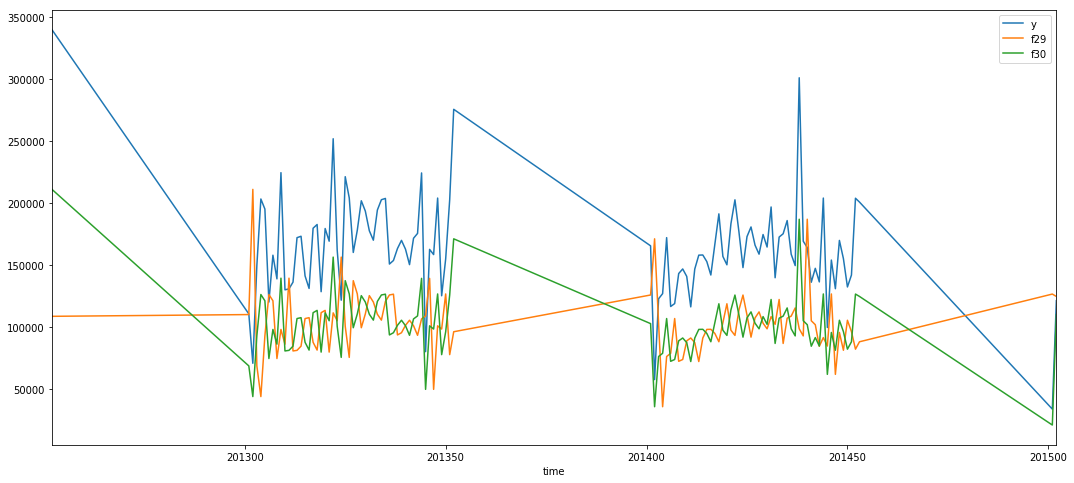

In [97]:
handle_train[:108][['y','f29','f30','time']].plot.line(x='time',figsize=(18,8))

In [19]:
# frac = 0.1 # доля примеров, используемых для обучения

# сэмплируем обучающую выборку на случай, если не хотим обучаться на всем
# train = train.sample(frac=frac, random_state=42)

X = train.drop(['Num','y'], axis=1)
y = train['y']
print(len(X), len(y))

72457 72457


In [12]:
%%time
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=43)
model.fit(X, y)

preds = model.predict(test.drop(['Num'], axis=1))

print(len(preds))
print(len(sample_submission))

2016
2016
Wall time: 9.08 s


In [13]:
sample_submission['y'] = preds

NameError: name 'preds' is not defined

In [14]:
sample_submission.head(5)

,Num,y
0,348622,198575.912031
1,348623,198575.912031
2,348624,198575.912031
3,348625,198575.912031
4,348626,198575.912031


В прогнозах GBM могут появиться отрицательные числа:

In [15]:
print(sample_submission[sample_submission['y'] < 0])

Empty DataFrame
Columns: [Num, y]
Index: []


Если они есть - можем занулить:

In [16]:
sample_submission['y'] = sample_submission['y'].map(lambda x: x if x > 0 else 0.0)

In [17]:
sample_submission.to_csv("baseline_submission.tsv", sep=',', index=False)

In [55]:
lll = [[1,2],[3,4]]
lll[[:,1]]

SyntaxError: invalid syntax (<ipython-input-55-f9b71e752ab5>, line 2)

In [90]:
print(sys.path)

['C:\\Users\\Xiaomi\\JN\\mail.ru\\homework2', 'C:\\Users\\Xiaomi\\Anaconda3\\python37.zip', 'C:\\Users\\Xiaomi\\Anaconda3\\DLLs', 'C:\\Users\\Xiaomi\\Anaconda3\\lib', 'C:\\Users\\Xiaomi\\Anaconda3', '', 'C:\\Users\\Xiaomi\\Anaconda3\\lib\\site-packages', 'C:\\Users\\Xiaomi\\Anaconda3\\lib\\site-packages\\win32', 'C:\\Users\\Xiaomi\\Anaconda3\\lib\\site-packages\\win32\\lib', 'C:\\Users\\Xiaomi\\Anaconda3\\lib\\site-packages\\Pythonwin', 'C:\\Users\\Xiaomi\\Anaconda3\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\Xiaomi\\.ipython']
